# Run only when in Google Colab

In [ ]:
# RUN ONLY ONCE
from google.colab import drive
drive.mount('/content/drive')
dataset = '/content/drive/MyDrive/Datasets/SUBESCO'

# Run only when in offline 

In [1]:
dataset = '..\\Datasets\\SUBESCO'

In [2]:
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display as lrd
import matplotlib.pyplot as plt
import seaborn as sb
# from vscode_audio import Audio
from IPython.display import Audio
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
files = []
emo = []

for dirpath, dirnames, filenames in os.walk(dataset):
    # print(dirnames, filenames)
    print(len(filenames), len(dirnames))
    for filename in filenames:
        x = os.path.join(dirpath, filename)
        # print(x)
        files.append(x)
        y = x.split('_')[-2].lower()
        emo.append(y)

# files[0].split('_')[-2].lower()
# emo
# len(files), len(emo)

7000 0


In [4]:
d = pd.DataFrame()
d['sound'] = files
d['emotion'] = emo

d.head()

,sound,emotion
0,..\Datasets\SUBESCO\F_01_OISHI_S_10_ANGRY_1.wav,angry
1,..\Datasets\SUBESCO\F_01_OISHI_S_10_ANGRY_2.wav,angry
2,..\Datasets\SUBESCO\F_01_OISHI_S_10_ANGRY_3.wav,angry
3,..\Datasets\SUBESCO\F_01_OISHI_S_10_ANGRY_4.wav,angry
4,..\Datasets\SUBESCO\F_01_OISHI_S_10_ANGRY_5.wav,angry


<AxesSubplot:xlabel='emotion', ylabel='count'>

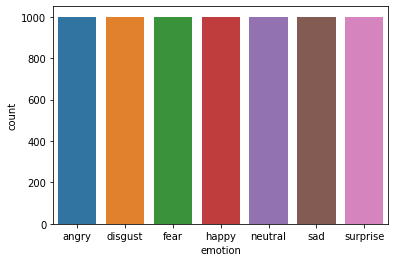

In [5]:
sb.countplot(x='emotion', data=d)

In [6]:
def waveplot(data, sr, title):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    lrd.waveshow(data, sr=sr)
    plt.show()

def spectograph(data, sr, title):
    x = lr.stft(data)
    xdb = lr.amplitude_to_db(abs(x))
    plt.figure(figsize=(12, 4))
    plt.title(title)
    lrd.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def getPath(EType):
    return np.array(d['sound'][d['emotion'] == EType])[1]

def getInfo(EType):
    path = getPath(EType)
    data, sr = lr.load(path)
    waveplot(data, sr, EType)
    spectograph(data, sr, EType)


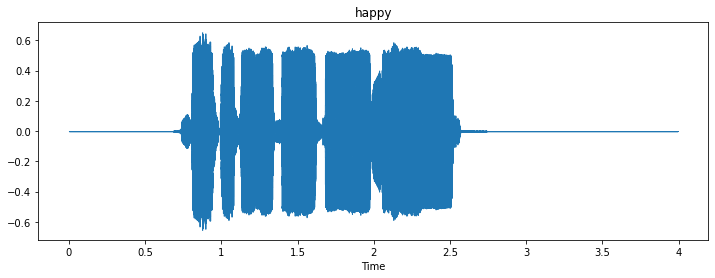

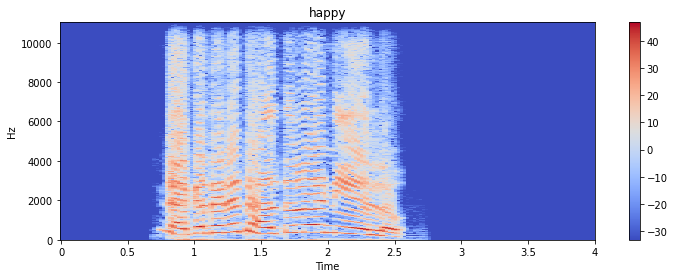

In [7]:
EType = 'happy'
getInfo(EType)
Audio(getPath(EType))

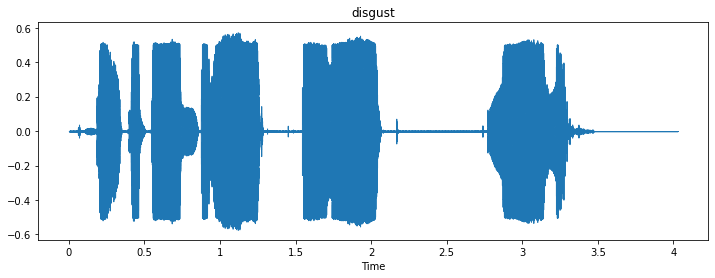

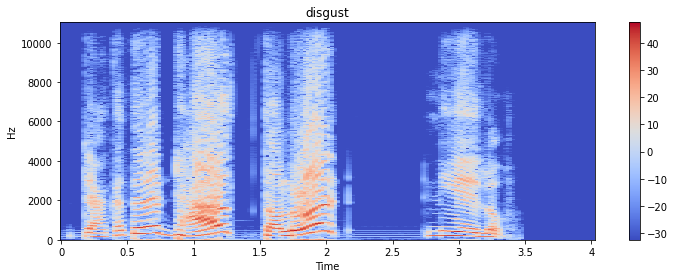

In [8]:
EType = 'disgust'
getInfo(EType)
Audio(getPath(EType))

# Data Augmentation

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return lr.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return lr.effects.pitch_shift(data, sampling_rate, pitch_factor)

# path = getPath('happy')
# data, sr = lr.load(path)
# x = noise(data)
# waveplot(x, sr, 'Noise Test')
# spectograph(x, sr, 'Noise Test')
# Audio(x, sr)

## Shuffling
# d = d.sample(frac=1).reset_index(drop=True)
# d.head()

# Feature Extraction

In [10]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(lr.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(lr.stft(data))
    chroma_stft = np.mean(lr.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(lr.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(lr.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(lr.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = lr.load(path, duration=2.5, offset=0.6, sr=8025) # Downsampling to 8000 Hz
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [11]:
from tqdm import tqdm
X, Y = [], []
for path, emotion in tqdm(zip(d['sound'], d['emotion'])):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

0it [00:00, ?it/s]C:\Users\samin\AppData\Local\Temp\ipykernel_1388\3237267747.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return lr.effects.time_stretch(data, rate)
C:\Users\samin\AppData\Local\Temp\ipykernel_1388\3237267747.py:14: FutureWarning: Pass sr=8025, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return lr.effects.pitch_shift(data, sampling_rate, pitch_factor)
7000it [25:37,  4.55it/s]


In [12]:
len(X), len(Y)

(21000, 21000)

In [ ]:
X_numpy = np.array(X)
Y_numpy = np.array(Y)
np.save('X_numpy.npy', X_numpy)
np.save('Y_numpy.npy', Y_numpy)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()
Features.shape

# Input split

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
# y = y.toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=0, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size= 0.25, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

# Models

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

# LTSM

In [ ]:
model = Sequential([
    LSTM(123, return_sequences=False, input_shape=x_train.shape[1:3]),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

### Training

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./models/all_features_lstm.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=512, shuffle=True, callbacks=[es, mc])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


sb.lineplot(x=range(len(acc)), y=acc, label='Training Accuracy')
sb.lineplot(x=range(len(val_acc)), y=val_acc, label='Validation Accuracy')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

sb.lineplot(x=range(len(loss)), y=loss, label='Training Loss')
sb.lineplot(x=range(len(val_loss)), y=val_loss, label='Validation Loss')

### Testing

In [ ]:
saved_model = load_model('./models/all_features_lstm.h5')
train_loss, train_acc = saved_model.evaluate(x_train, y_train, verbose=1)
test_loss, test_acc = saved_model.evaluate(x_test, y_test, verbose=1)

In [ ]:
sb.barplot(x=['train', 'test'], y=[train_acc, test_acc], palette=['red', 'blue']).set_title('Training and Testing Accuracy')

In [ ]:
sb.barplot(x=['train', 'test'], y=[train_loss, test_loss], palette=['red', 'blue']).set_title('Training and Testing Loss')

# CNN

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./models/all_features_cnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./models/all_features_cnn.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [29]:
def cnn1():
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same', input_shape=(x_train.shape[1],1)))  # No. of Columns
    model.add(Activation('relu'))
    model.add(Conv1D(256, 8, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(128, 8, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(64, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv1D(64, 8, padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1])) # Number of emotions
    model.add(Activation('softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

def cnn2():
    model=Sequential()
    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(units=y_train.shape[1], activation='softmax'))
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model

In [30]:
modelCnn = cnn2()

modelCnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 182, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 91, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 91, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 23, 128)         

In [31]:
history2 = modelCnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=512, shuffle=True, callbacks=[es, mc])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.7535 - accuracy: 0.2751
Epoch 1: val_loss improved from inf to 1.62234, saving model to ./models\all_features_cnn.h5
31/31 [==============================] - 54s 2s/step - loss: 1.7535 - accuracy: 0.2751 - val_loss: 1.6223 - val_accuracy: 0.3592
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 1.5916 - accuracy: 0.3576
Epoch 2: val_loss improved from 1.62234 to 1.46797, saving model to ./models\all_features_cnn.h5
31/31 [==============================] - 53s 2s/step - loss: 1.5916 - accuracy: 0.3576 - val_loss: 1.4680 - val_accuracy: 0.4288
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 1.4801 - accuracy: 0.4074
Epoch 3: val_loss improved from 1.46797 to 1.35091, saving model to ./models\all_features_cnn.h5
31/31 [==============================] - 52s 2s/step - loss: 1.4801 - accuracy: 0.4074 - val_loss: 1.3509 - val_accuracy: 0.4779
Epoch 4/50
31/31 [==========================

<AxesSubplot:>

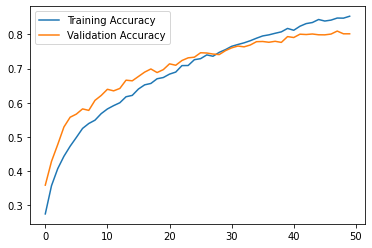

In [32]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

sb.lineplot(x=range(len(acc)), y=acc, label='Training Accuracy')
sb.lineplot(x=range(len(val_acc)), y=val_acc, label='Validation Accuracy')

<AxesSubplot:>

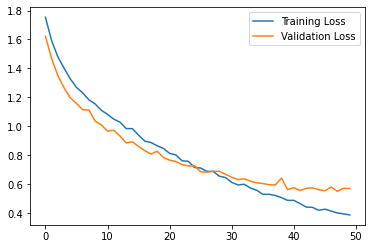

In [33]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

sb.lineplot(x=range(len(loss)), y=loss, label='Training Loss')
sb.lineplot(x=range(len(val_loss)), y=val_loss, label='Validation Loss')

132/132 [==============================] - 3s 23ms/step - loss: 0.5506 - accuracy: 0.8095


Text(0.5, 1.0, 'Training and Testing Accuracy')

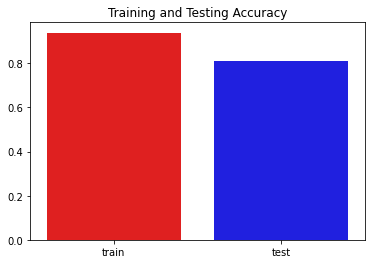

In [34]:
saved_model = load_model('./models/all_features_cnn.h5')
train_loss, train_acc = saved_model.evaluate(x_train, y_train, verbose=1)
test_loss, test_acc = saved_model.evaluate(x_test, y_test, verbose=1)
sb.barplot(x=['train', 'test'], y=[train_acc, test_acc], palette=['red', 'blue']).set_title('Training and Testing Accuracy')